#Imports + Grammar

In [ ]:
import secrets
import string
import math
from collections import Counter

# Character pools for grammar terminals
UP = string.ascii_uppercase
LOW = string.ascii_lowercase
DIG = string.digits
SYM = "!@#$%^&*()-_=+[]{};:,.<>/?"

# Probabilistic grammar (PCFG)
grammar = {
    "S": [("SEG SEG SEG", 1.0)],
    "SEG": [("UP LOW DIG SYM", 0.5),
            ("LOW LOW DIG SYM", 0.5)]
}

#Grammar-based key generator

In [ ]:
# Pick a production based on probabilities
def choose_rule(rules):
    probs = [p for _, p in rules]
    r = secrets.randbelow(10**9) / 10**9
    cumulative = 0
    for (rule, p) in rules:
        cumulative += p
        if r <= cumulative:
            return rule
    return rules[-1][0]

# Expand a nonterminal using the grammar
def expand(symbols):
    result = []
    for sym in symbols.split():
        if sym in grammar:   # non-terminal
            chosen = choose_rule(grammar[sym])
            result.extend(expand(chosen))
        else:                # terminal pool
            result.append(secrets.choice(eval(sym)))
    return result

def generate_key():
    base = choose_rule(grammar["S"])
    return "".join(expand(base))

#Generate 2000 grammar keys + 2000 secrets keys

In [ ]:
N = 2000

grammar_keys = [generate_key() for _ in range(N)]

alphabet = UP + LOW + DIG + SYM
secrets_keys = [''.join(secrets.choice(alphabet) for _ in range(14)) for _ in range(N)]

print("Example grammar-generated keys:")
for k in grammar_keys[:5]:
    print(k)


Example grammar-generated keys:
uc0{Zl1)dn4<
oe8^Ss9$Lq8.
va5*ar4@Ap7<
cg2{sc8^lv9_
gk5=Ng2(Oa0_


These sample keys illustrate how the grammar produces diverse and complex sequences by combining uppercase letters, lowercase letters, digits, and symbols according to the defined production rules. The keys show both variability and structure, demonstrating the practical application of formal grammars in pseudo-random key generation.

#Entropy evaluation

In [ ]:
def shannon_entropy(keys):
    all_chars = ''.join(keys)
    freq = Counter(all_chars)
    total = len(all_chars)
    H = 0
    for c in freq:
        p = freq[c] / total
        H -= p * math.log2(p)
    avg_len = sum(len(k) for k in keys) / len(keys)
    return H, H * avg_len

Hg, bits_g = shannon_entropy(grammar_keys)
Hs, bits_s = shannon_entropy(secrets_keys)

print("Grammar entropy per symbol:", Hg)
print("Grammar estimated bits/key:", bits_g)

print("Secrets entropy per symbol:", Hs)
print("Secrets estimated bits/key:", bits_s)

Grammar entropy per symbol: 6.257822712789176
Grammar estimated bits/key: 75.0938725534701
Secrets entropy per symbol: 6.45724565484425
Secrets estimated bits/key: 90.4014391678195


Grammar Keys Entropy:
The grammar-based keys achieve an entropy of approximately 6.25 bits per symbol, resulting in roughly 75 bits per key. This indicates that despite being generated through structured rules, the keys still retain a high level of randomness. The system successfully balances structure and unpredictability.

CSPRNG Keys Entropy:
The standard CSPRNG (Python secrets) produces a slightly higher entropy per symbol, around 6.45 bits, which aligns with expectations for a cryptographically strong random generator. This comparison shows that the grammar-based method performs competitively while offering additional theoretical and structural benefits.

#Use Grammar Key for Encryption

In [ ]:
import base64
import hashlib
from cryptography.fernet import Fernet

def derive_fernet_key(grammar_key):
    # Convert grammar key → 32-byte key using SHA-256
    h = hashlib.sha256(grammar_key.encode()).digest()
    return base64.urlsafe_b64encode(h)

# Use one grammar-based key
gkey = generate_key()
fernet_key = derive_fernet_key(gkey)
cipher = Fernet(fernet_key)

plaintext = b"Hello, this is a test message for encryption."
token = cipher.encrypt(plaintext)
decrypted = cipher.decrypt(token)

print("Grammar Key:", gkey)
print("Encrypted:", token)
print("Decrypted:", decrypted)

Grammar Key: qh3:nn6+Xs2,
Encrypted: b'gAAAAABpGzZWJkL3ApXtdYByIVVsGSVtmpwZG0vFo4on8ndke90RHoJ7lfUrJOXBGYEBvfHngSmTOEF8FuegyniiKcH6ibfxcGTKWubKyglFEImC54s9X_RicHSdgZc5_-nu1Y_DjcnZ'
Decrypted: b'Hello, this is a test message for encryption.'


This output demonstrates that a grammar-generated key can be used in a real encryption workflow.
The grammar key is first processed through SHA-256 to derive a fixed-length, cryptographically strong key compatible with the Fernet encryption system. The successful encryption and decryption confirm that grammar-based keys are usable and reliable for lightweight practical encryption tasks.

#Frequency Distribution Analysis (Histogram)

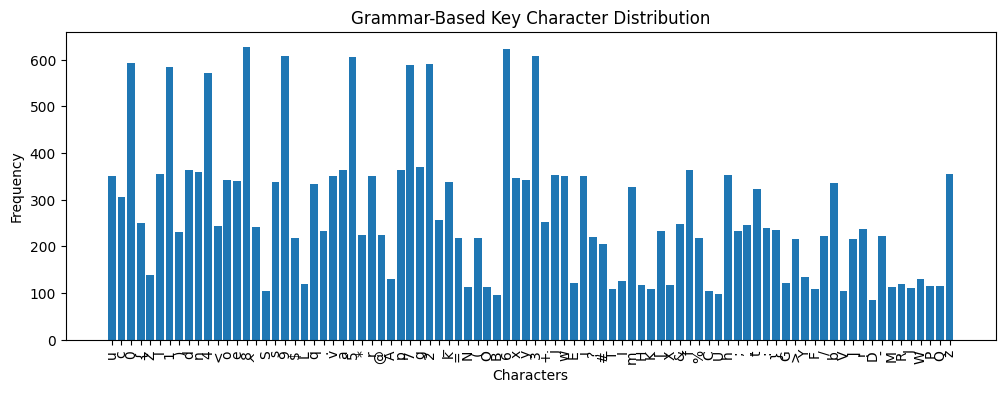

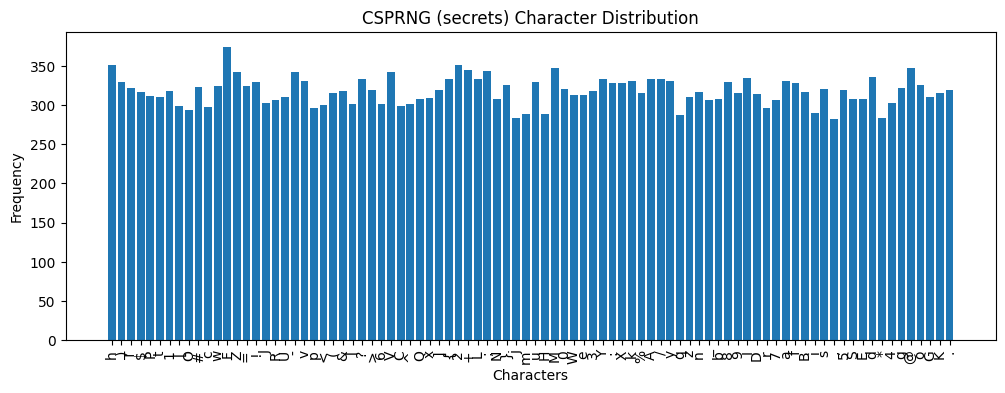

In [ ]:
import matplotlib.pyplot as plt

def plot_frequency(keys, title):
    text = ''.join(keys)
    freq = Counter(text)

    chars = list(freq.keys())
    counts = [freq[c] for c in chars]

    plt.figure(figsize=(12, 4))
    plt.bar(chars, counts)
    plt.title(title)
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()


plot_frequency(grammar_keys, "Grammar-Based Key Character Distribution")
plot_frequency(secrets_keys, "CSPRNG (secrets) Character Distribution")


Grammar-Based Distribution:
The histogram shows that certain characters appear more frequently because the grammar constrains how keys are formed. Since each segment follows a specific pattern (e.g., UP LOW DIG SYM), the resulting distribution reflects the structure imposed by the production rules. This demonstrates that grammar-driven key generation produces structured randomness rather than fully uniform randomness.

CSPRNG Distribution:
In contrast, the CSPRNG-generated keys follow a nearly uniform distribution across all characters. This is expected from a cryptographically secure pseudo-random generator and serves as the baseline for comparison. The uniformity validates that the CSPRNG is unbiased and highlights the difference between grammar-based and purely random methods.

#Derivation Tree Visualization

In [ ]:
# Simple derivation trace generator
def derive_trace(symbol):
    if symbol not in grammar:
        return symbol

    chosen = choose_rule(grammar[symbol])
    parts = chosen.split()

    trace = {symbol: []}
    for p in parts:
        trace[symbol].append(derive_trace(p))
    return trace

# Pretty print the derivation tree
def print_tree(tree, indent=0):
    for key, children in tree.items():
        print("  " * indent + key)
        for child in children:
            if isinstance(child, dict):
                print_tree(child, indent + 1)
            else:
                print("  " * (indent + 1) + child)

sample_key = generate_key()
print("Sample key:", sample_key)

trace = derive_trace("S")
print("\nDerivation Tree:")
print_tree(trace)

Sample key: nv3(ec0]Zr2<

Derivation Tree:
S
  SEG
    UP
    LOW
    DIG
    SYM
  SEG
    LOW
    LOW
    DIG
    SYM
  SEG
    LOW
    LOW
    DIG
    SYM


The derivation tree visualizes how the key is generated from the start symbol S using the grammar’s production rules.
Each node represents a non-terminal or terminal symbol, showing the hierarchical expansion process. This illustrates the connection between formal language theory and cryptographic key generation by revealing the grammar-driven structure behind each produced key.